# DS 3000 - Assignment 11

**Student Name**: David Yu

**Date**: 3/28/25


### Submission Instructions
Submit this `ipynb` file to canvas.

The `ipynb` format stores outputs from the last time you ran the notebook.  (When you open a notebook it has the figures and outputs of the last time you ran it too).  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh run `Kernel > Restart & Run All` just before uploading the `ipynb` file to Canvas.

### Academic Integrity

**Writing your homework is an individual effort.**  You may discuss general python problems with other students but under no circumstances should you observe another student's code which was written for this assignment, from this year or past years.  Pop into office hours or DM us in MS Teams if you have a specific question about your work or if you would like another pair of eyes or talk through your code.

Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment. You do not need to cite the official python documentation.

**Documentation / style counts for credit**  Please refer to the Pep-8 style, to improve the readability and consistency of your Python code. For more information, read the following article [How to Write Beautiful Python Code With PEP 8](https://realpython.com/python-pep8/) or ask your TA's for tips.

**NOTE:<span style='color:red'> Write python expressions to answer ALL questions below and ensure that you use the `print()` function to display the output.</span>** Each question should be answered in a new code cell. For example, your solution for question 1.1 should be in a different code cell from your solution for question 1.2.

## Question 1: 

(2 pts) Load the dataset "diabetes.csv", view the dimensions of the data, and gather summary statistics. Comment on your observations about the data.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.feature_selection import f_regression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer

In [8]:
df = pd.read_csv('diabetes.csv')

print("Dataset Dimensions:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print("\nSummary Statistics:")
print(df.describe())

Dataset Dimensions:
Number of rows: 768
Number of columns: 9

Summary Statistics:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160      

- The mean of the Outcome variable is 0.349, which means about 35% of patients have diabetes while 65% don't.
- All patients are at least 21 years old, with the oldest being 81.
- Pregnancies have a pretty wide range of 0 - 17.
- BMI has a mean of about 32, which is in the obese category.
- Glucose ranges from 0 to 199.

## Question 2:
(5 pts) Create two visualizations that demonstrate univariate and/or pairwise patterns in the data. Comment on the patterns.


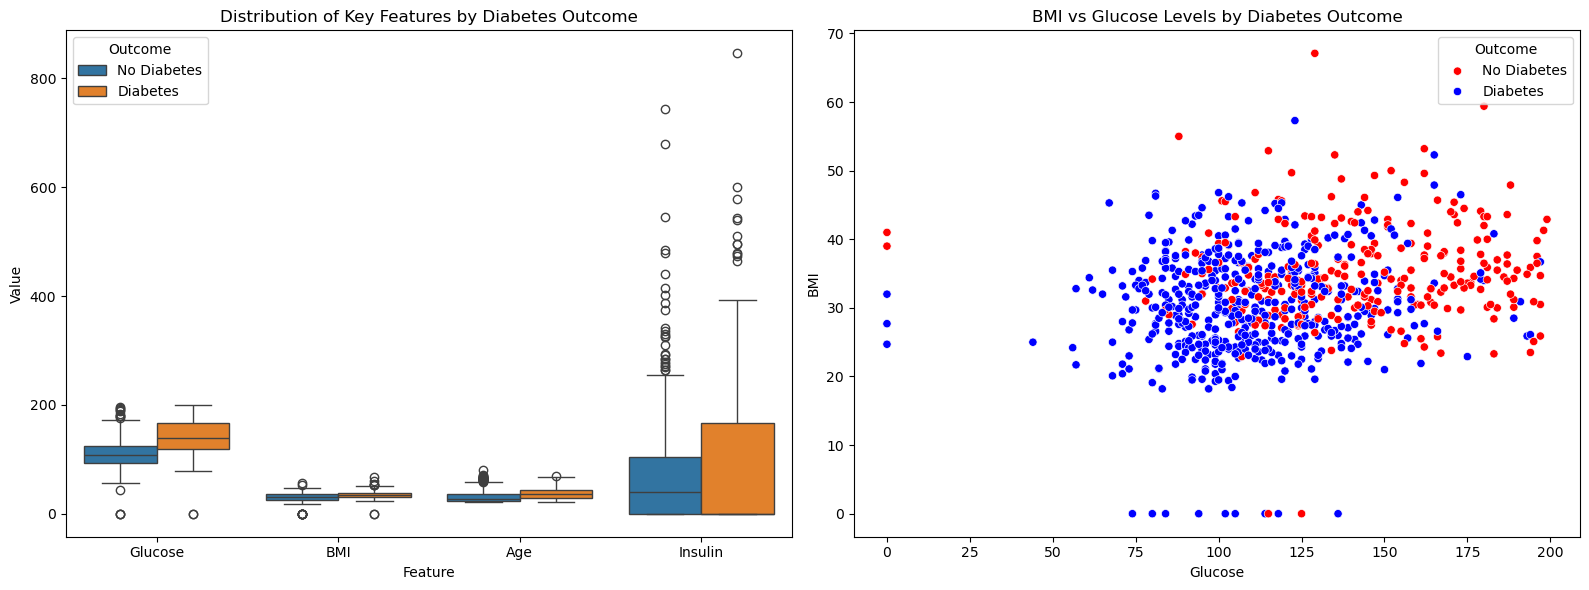

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Unvariate Patterns
selected_columns = ['Glucose', 'BMI', 'Age', 'Insulin']
df_melted = pd.melt(df, id_vars=['Outcome'], value_vars=selected_columns, 
                    var_name='Feature', value_name='Value')

sns.boxplot(x='Feature', y='Value', hue='Outcome', data=df_melted, ax=axes[0])
axes[0].set_title('Distribution of Key Features by Diabetes Outcome')
axes[0].set_xlabel('Feature')
axes[0].set_ylabel('Value')
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, ['No Diabetes', 'Diabetes'], title='Outcome')

# Pairwise Patterns
scatter = sns.scatterplot(x='Glucose', y='BMI', hue='Outcome', 
                         data=df, palette=['blue', 'red'], ax=axes[1])
axes[1].set_title('BMI vs Glucose Levels by Diabetes Outcome')
axes[1].set_xlabel('Glucose')
axes[1].set_ylabel('BMI')
axes[1].legend(title='Outcome', labels=['No Diabetes', 'Diabetes'])

plt.tight_layout()
plt.show()

### Univariate Patterns
- Glucose levels are higher in patients with diabetes compared to patients without diabetes.
- BMI and age in patients with diabetes is slightly higher than patients without diabetes. However, the difference is very minor.
- Insulin shows a lot of variability, with numerous outliers in both patients with and without diabetes.

### Pairwise Patterns
- There is a lot of overlap in BMI values between both patients with and without diabetes.
- Points with high glucose and high BMI are likely to be patients with diabetes.
- No clear linear relationship between BMI and glucose.

## Question 3: (5 pts) Feature Selection
Demonstrate which features are useful to build the model. Briefly explain the reason for the features that you selected. Note: You can explore correlations, test hypothesis and/or other techniques. Remember that Data Science relies heavily on experimentation. Therefore, you are encouraged to experiment with your data.
- Tip #1: ensure that you carefully consider each feature and share the pros and cons of your decisions.
- Tip #2: you are predicting the birth weight, therefore it should not be one of your explanatory variables.

Number of samples: 1236
Number of features: 6
Features: ['gestation', 'parity', 'age', 'height', 'weight', 'smoke']

Pearson Correlation Analysis: 
Correlations with birth weight:
 gestation: 0.4058
    parity: -0.0461
       age: 0.0337
    height: 0.1973
    weight: 0.1520
     smoke: -0.2406

Strongly correlated features (|r| > 0.3):
parity ~ age: -0.3500
height ~ weight: 0.4300

F-regression Analysis: 
F-statistics and p-values:
              F_Score       P_Value
gestation  243.228240  3.454856e-50
smoke       75.835012  9.730642e-18
height      49.961289  2.616876e-12
weight      29.176544  7.920945e-08
parity       2.628951  1.051865e-01
age          1.400338  2.368948e-01

Statistical Tests for Categorical Variables: 
Smoking T-test: t=8.6398, p=0.00000000
Mean difference: 8.99 ounces
Parity T-test: t=1.6863, p=0.09227866
Mean difference: -1.93 ounces

Cross-Validation Performance with Different Feature Sets:
gestation_only: Mean R^2 = 0.1479 (±0.0432)
gestation_smoke: Mean R^2

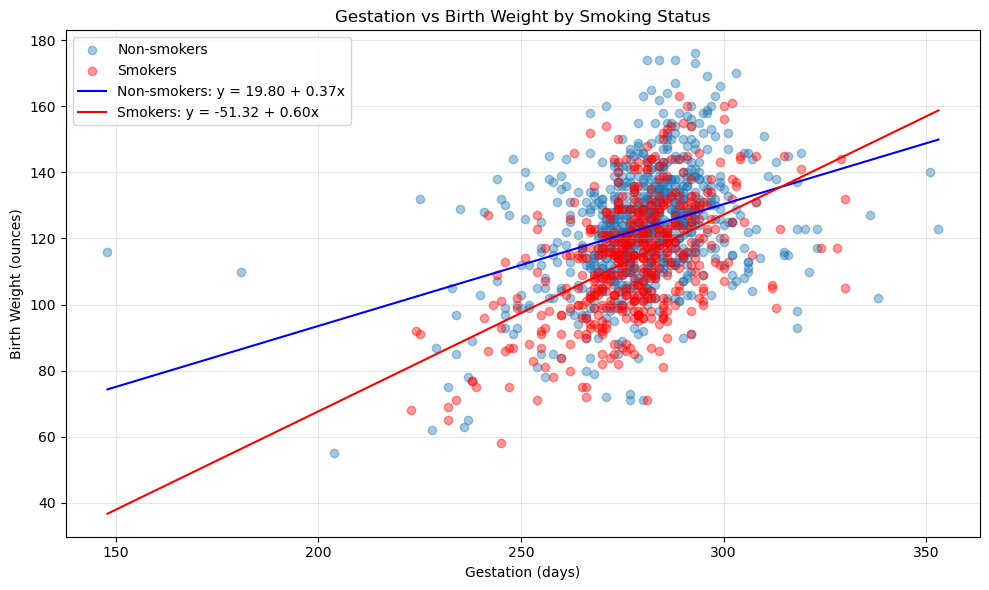


Final Feature Importance Summary: 
     Feature  Correlation     F_Score       P_Value  Avg_Rank
0  gestation     0.405773  243.228240  3.454856e-50       1.0
5      smoke    -0.240617   75.835012  9.730642e-18       2.0
3     height     0.197261   49.961289  2.616876e-12       3.0
4     weight     0.151979   29.176544  7.920945e-08       4.0
1     parity    -0.046107    2.628951  1.051865e-01       5.0
2        age     0.033668    1.400338  2.368948e-01       6.0


In [72]:
X = df_clean.drop(['bwt', 'case'], axis=1)  # Remove target and ID
y = df_clean['bwt']
features = X.columns.tolist()

print("Number of samples:", len(df_clean))
print("Number of features:", len(features))
print("Features:", features)

# Correlation Analysis
print("\nPearson Correlation Analysis: ")
correlations = df_clean.drop('case', axis=1).corr()['bwt'].drop('bwt')
abs_correlations = correlations.abs().sort_values(ascending=False)

print("Correlations with birth weight:")
for feature, corr in correlations.items():
    print(f"{feature:>10}: {corr:.4f}")

# Feature Correlation
print("\nStrongly correlated features (|r| > 0.3):")
for i, feat1 in enumerate(features):
    for j, feat2 in enumerate(features):
        if i < j:
            corr = correlation_matrix.loc[feat1, feat2]
            if abs(corr) > 0.3:
                print(f"{feat1} ~ {feat2}: {corr:.4f}")

# F-regression Analysis
print("\nF-regression Analysis: ")
# Calculate F-statistics and p-values
f_values, p_values = f_regression(X, y)
f_scores = pd.Series(f_values, index=features)
p_values = pd.Series(p_values, index=features)

# Combine scores and p-values
feature_scores = pd.DataFrame({
    'F_Score': f_scores,
    'P_Value': p_values
})
feature_scores = feature_scores.sort_values('F_Score', ascending=False)

print("F-statistics and p-values:")
print(feature_scores)

# Statistical Tests for Categorical Variables
print("\nStatistical Tests for Categorical Variables: ")

# Smoking
smoker_bwt = df_clean[df_clean['smoke'] == 1]['bwt']
nonsmoker_bwt = df_clean[df_clean['smoke'] == 0]['bwt']
t_stat, p_val = stats.ttest_ind(nonsmoker_bwt, smoker_bwt, equal_var=False)
print(f"Smoking T-test: t={t_stat:.4f}, p={p_val:.8f}")
print(f"Mean difference: {nonsmoker_bwt.mean() - smoker_bwt.mean():.2f} ounces")

# Parity
first_bwt = df_clean[df_clean['parity'] == 0]['bwt']
not_first_bwt = df_clean[df_clean['parity'] == 1]['bwt']
t_stat, p_val = stats.ttest_ind(first_bwt, not_first_bwt, equal_var=False)
print(f"Parity T-test: t={t_stat:.4f}, p={p_val:.8f}")
print(f"Mean difference: {not_first_bwt.mean() - first_bwt.mean():.2f} ounces")

# Incremental Feature Testing with Cross-Validation
print("\nCross-Validation Performance with Different Feature Sets:")

feature_sets = {
    'gestation_only': ['gestation'],
    'gestation_smoke': ['gestation', 'smoke'],
    'gestation_smoke_height': ['gestation', 'smoke', 'height'],
    'all_features': features
}

# Test each feature set with cross-validation
cv_results = {}
for name, feature_set in feature_sets.items():
    model = LinearRegression()
    X_subset = df_clean[feature_set]
    
    scores = cross_val_score(model, X_subset, y, cv=5, scoring='r2')
    
    cv_results[name] = {
        'mean_r2': scores.mean(),
        'std_r2': scores.std(),
        'features': feature_set
    }
    
    print(f"{name}: Mean R^2 = {scores.mean():.4f} (±{scores.std():.4f})")

# Interaction Analysis (Smoking and Gestation)
print("\nPotential Interaction Effects: ")

# Analyze interaction by fitting separate models for each group
smokers = df_clean[df_clean['smoke'] == 1]
nonsmokers = df_clean[df_clean['smoke'] == 0]

# Fit linear regression for each group
smoker_model = LinearRegression().fit(smokers[['gestation']], smokers['bwt'])
nonsmoker_model = LinearRegression().fit(nonsmokers[['gestation']], nonsmokers['bwt'])

print("Separate models by smoking status:")
print(f"Non-smokers: bwt = {nonsmoker_model.intercept_:.2f} + {nonsmoker_model.coef_[0]:.4f} * gestation")
print(f"Smokers: bwt = {smoker_model.intercept_:.2f} + {smoker_model.coef_[0]:.4f} * gestation")

# Plot interaction effect
plt.figure(figsize=(10, 6))
# Plot points and regression lines
plt.scatter(nonsmokers['gestation'], nonsmokers['bwt'], alpha=0.4, label='Non-smokers')
plt.scatter(smokers['gestation'], smokers['bwt'], alpha=0.4, color='red', label='Smokers')

# Create regression lines
xrange = np.linspace(df_clean['gestation'].min(), df_clean['gestation'].max(), 100)
plt.plot(xrange, nonsmoker_model.intercept_ + nonsmoker_model.coef_[0] * xrange, 'b-', 
         label=f'Non-smokers: y = {nonsmoker_model.intercept_:.2f} + {nonsmoker_model.coef_[0]:.2f}x')
plt.plot(xrange, smoker_model.intercept_ + smoker_model.coef_[0] * xrange, 'r-', 
         label=f'Smokers: y = {smoker_model.intercept_:.2f} + {smoker_model.coef_[0]:.2f}x')

plt.title('Gestation vs Birth Weight by Smoking Status')
plt.xlabel('Gestation (days)')
plt.ylabel('Birth Weight (ounces)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


print("\nFinal Feature Importance Summary: ")

summary = pd.DataFrame({
    'Feature': features,
    'Correlation': [correlations[f] for f in features],
    'Abs_Correlation': [abs(correlations[f]) for f in features],
    'F_Score': [f_scores[f] for f in features],
    'P_Value': [p_values[f] for f in features]
})

summary['Corr_Rank'] = summary['Abs_Correlation'].rank(ascending=False)
summary['F_Rank'] = summary['F_Score'].rank(ascending=False)
summary['Avg_Rank'] = (summary['Corr_Rank'] + summary['F_Rank']) / 2
summary = summary.sort_values('Avg_Rank')

print(summary[['Feature', 'Correlation', 'F_Score', 'P_Value', 'Avg_Rank']])

## Gestation Period
### Pros:
- Strongest correlation with birth weight with a value of 0.4
- Highest F-score of 243.23 with an extremely significant p-value
- Makes sense as longer pregnancies allow babies more time to develop and gain weight

### Cons:
- Some missing values in dataset
- Can't be changed or modified once pregnancy has begun

### Decision
We are going to include this as the primary predictor because of its strong statistical relationship and clear biological basis.

## Smoking Status
### Pros:
- Second strongest correlation of -0.24 and F-score of 75.84
- Highly significant effect with a very small p-value
- Adding smoking to gestation improves the R^2 value from 0.15 to 0.19

### Cons:
- Some missing values in dataset
- Doesn't include the smoking intensity or duration
- Self-reported data that may be unreliable

### Decision:
We are going to include smoking as a key predictor. There is a strong effect size and statistical significance.

### Mother's Height
### Pros:
- Moderate correlation of 0.20 with a significant F-value of 49.96
- Adding height to gestation and smoking improves R^2 to 0.22
- Objective measurement with good reliablility

### Cons:
- Characteristic cannot be modified
- Correlation with mother's weight (r=0.43) creates potential multicollinearity

### Decision:
We are going to include mother's height as it provides substantial predictive improvement and captures a distinct maternal characteristic.

### Gestation and Smoking Interaction
### Pros:
- Captures the differential effects of gestation by smoking status
- Regression coefficients show that smoking significantly modifies this relationship
- Non-smokers: bwt = 19.8 + 0.3686 * gestation
- Smokers: bwt = -51.32 + 0.5951 * gestation

### Cons:
- Requires both gestation and smoking to be reliable
- Makes model more complex

### Decision:
We are going to include this because it captures the important complexity in how our key predictors interact with each other.

## Mother's Weight
### Pros:
- Moderate correlation with 0.15 with signficant F-score of 29.18
- Adding weight slightly improves model perfomance

### Cons:
- Significant multicollinearity with height, r=0.43
- Current weight doesn't tell us as much as pre-pregnancy weight
- Not a lot of improvement in R^2 when added to model

### Decision:
We are going to exclude weight as a standalone predictor. There is too much multicollinearity.

## Parity
### Pros:
- No missing values
- Binary variable
- First babies do tend to be slightly smaller

### Cons:
- Weak correlation with a value of -0.05 and a low F-score of 2.63
- Non-siginficant p-value of 0.105
- T-tests show a marginal significance with a p=0.092

### Decision:
We are going to exlcude parity because of its weak statistical relationship. 

## Mother's Age
### Pros:
- Could have non-linear relationship with birth weight

### Cons:
- Weakest correlation of 0.03 and lowest F-score of 1.4
- Non-significant p-value of 0.237

### Decision:
We are going to exclude mother's age because of its weak statistical relationship.

## Final Features
- Gestation
- Smoking
- Mother's height
- Gestation and Smoking Interaction

## Question 4: Data Partitioning
(2 pts) Partition the prepared data into train/test sets, ensure that your partitions are reproducible. Encode any categorical variables in your training set. Then, use the appropriate approach to encode your test set.

In [59]:
df['gestation_x_smoke'] = df['gestation'] * df['smoke']

# Define features and target based on our feature selection
X = df[['gestation', 'smoke', 'height', 'gestation_x_smoke']]
y = df['bwt']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nTrain/Test split:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

categorical_features = ['smoke']

# Create OneHotEncoder for categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')

if categorical_features:
    encoder_fit = encoder.fit(X_train[categorical_features])
    
    encoded_train = encoder_fit.transform(X_train[categorical_features])
    
    encoded_feature_names = []
    for i, feature in enumerate(categorical_features):
        categories = encoder.categories_[i][1:] 
        for category in categories:
            encoded_feature_names.append(f"{feature}_{category}")
    
    encoded_train_df = pd.DataFrame(
        encoded_train, 
        columns=encoded_feature_names,
        index=X_train.index
    )
    
    X_train_encoded = X_train.drop(categorical_features, axis=1).join(encoded_train_df)
    
    encoded_test = encoder_fit.transform(X_test[categorical_features])
    encoded_test_df = pd.DataFrame(
        encoded_test, 
        columns=encoded_feature_names,
        index=X_test.index
    )
    X_test_encoded = X_test.drop(categorical_features, axis=1).join(encoded_test_df)
else:
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

print("\nAfter encoding:")
print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")
print("\nX_train_encoded columns:")
print(X_train_encoded.columns.tolist())
print("\nFirst 5 rows of X_train_encoded:")
print(X_train_encoded.head())


Train/Test split:
X_train shape: (988, 4)
X_test shape: (248, 4)
y_train shape: (988,)
y_test shape: (248,)

After encoding:
X_train_encoded shape: (988, 5)
X_test_encoded shape: (248, 5)

X_train_encoded columns:
['gestation', 'height', 'gestation_x_smoke', 'smoke_1.0', 'smoke_nan']

First 5 rows of X_train_encoded:
      gestation  height  gestation_x_smoke  smoke_1.0  smoke_nan
946       289.0    67.0              289.0        1.0        0.0
394       313.0    59.0              313.0        1.0        0.0
1023      287.0    62.0                0.0        0.0        0.0
816       280.0    65.0              280.0        1.0        0.0
88        305.0    70.0              305.0        1.0        0.0


## Question 5: Model Development
(3 pts) Using the Random Forest algorithm, build a machine learning model that predicts the birth weight.
Think about the following: Are you performing classification or regression? Ensure that you choose the appropriate Random Forest Classifier/Regressor from scikit-learn.

In [60]:
df['gestation_x_smoke'] = df['gestation'] * df['smoke']

X = df[['gestation', 'smoke', 'height', 'gestation_x_smoke']]
y = df['bwt']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Encode categorical variables
categorical_features = ['smoke']
encoder = OneHotEncoder(sparse_output=False, drop='first')

# Fit and transform training data
if categorical_features:
    encoder_fit = encoder.fit(X_train[categorical_features])
    encoded_train = encoder_fit.transform(X_train[categorical_features])
    
    encoded_feature_names = []
    for i, feature in enumerate(categorical_features):
        categories = encoder.categories_[i][1:]
        for category in categories:
            encoded_feature_names.append(f"{feature}_{category}")
    
    
    encoded_train_df = pd.DataFrame(
        encoded_train, 
        columns=encoded_feature_names,
        index=X_train.index
    )
    X_train_encoded = X_train.drop(categorical_features, axis=1).join(encoded_train_df)
    
    encoded_test = encoder_fit.transform(X_test[categorical_features])
    encoded_test_df = pd.DataFrame(
        encoded_test, 
        columns=encoded_feature_names,
        index=X_test.index
    )
    X_test_encoded = X_test.drop(categorical_features, axis=1).join(encoded_test_df)
else:
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_encoded, y_train)

y_pred = rf_model.predict(X_test_encoded)

print("Random Forest Regressor for birth weight prediction is built and trained.")

Random Forest Regressor for birth weight prediction is built and trained.


Using a Random Forest Regressor because birth weight is continuous.

## Question 6: Model Evaluation
(2 pts) Evaluate the predictions from your model and comment on the results. Ensure that you choose the appropriate metric to evaluate the model and round your calculations to two decimal places. Remember that we evaluate models differently depending on the task, i.e. classification or regression.

In [58]:
# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
mse = round(mse, 2)

# Root Mean Squared Error
rmse = math.sqrt(mse)
rmse = round(rmse, 2)

# Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
mae = round(mae, 2)

# R-squared
r2 = r2_score(y_test, y_pred)
r2 = round(r2, 2)

print("Random Forest Regression Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R^2 Score: {r2}")

Random Forest Regression Model Evaluation:
Mean Squared Error (MSE): 325.98
Root Mean Squared Error (RMSE): 18.05
Mean Absolute Error (MAE): 14.62
R^2 Score: 0.17


## Question 7: Model Tuning
(10 pts) What are your thoughts on the model's prediction capability? Did it do a good job of predicting the birth weight? Justify your response.
Note: it is okay if your first version of the model is not the best. However, there are strategies that we can use to improve it, such as tuning.
- Tune the model: you can control the number of trees in your forest using the n_estimators parameter. Refer to the sample code from the lecture and also view the documentation**Links to an external site. to learn more about this algorithm and its parameters. Try at least 10 different values for the n_estimators parameter (excluding the default value) to determine if the model improved. Show all your steps to create, evaluate and tune each version of the model.
- Indicate which model performed the best.

In [63]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = round(math.sqrt(mse), 2)
    r2 = round(r2_score(y_test, y_pred), 2)
    
    return rmse, r2

default_model = RandomForestRegressor(random_state=42)
default_rmse, default_r2 = evaluate_model(default_model, X_train_encoded, X_test_encoded, y_train, y_test)

print(f"Default model (n_estimators=100):")
print(f"RMSE: {default_rmse}")
print(f"R^2: {default_r2}")

n_estimators_values = [10, 50, 150, 200, 250, 300, 350, 400, 450, 500]
results = []

print("\nTuning with different n_estimators values:")
for n_est in n_estimators_values:
    model = RandomForestRegressor(n_estimators=n_est, random_state=42)
    rmse, r2 = evaluate_model(model, X_train_encoded, X_test_encoded, y_train, y_test)
    
    results.append({
        'n_estimators': n_est,
        'RMSE': rmse,
        'R^2': r2
    })
    
    print(f"n_estimators={n_est}, RMSE={rmse}, R^2={r2}")

results_df = pd.DataFrame(results)

best_model = results_df.loc[results_df['RMSE'].idxmin()]
print(f"\nBest model: n_estimators={best_model['n_estimators']}")
print(f"RMSE: {best_model['RMSE']}")
print(f"R^2: {best_model['R^2']}")

Default model (n_estimators=100):
RMSE: 18.05
R^2: 0.17

Tuning with different n_estimators values:
n_estimators=10, RMSE=18.13, R^2=0.17
n_estimators=50, RMSE=17.87, R^2=0.19
n_estimators=150, RMSE=18.0, R^2=0.18
n_estimators=200, RMSE=17.94, R^2=0.18
n_estimators=250, RMSE=17.92, R^2=0.19
n_estimators=300, RMSE=17.91, R^2=0.19
n_estimators=350, RMSE=17.92, R^2=0.19
n_estimators=400, RMSE=17.93, R^2=0.19
n_estimators=450, RMSE=17.9, R^2=0.19
n_estimators=500, RMSE=17.92, R^2=0.19

Best model: n_estimators=50.0
RMSE: 17.87
R^2: 0.19


After tuning the model, the best model used n_estimators=50 and had a RMSE of 17.87 ounces and a R^2 of 0.19. Overall, the model's prediciton capability isn't the best. The model's R^2 value of 0.19 means that only about 19% of the variance in birth weight can be explained by the model. This is a pretty low amount of explained variance, meaning there is still a lot of important factors in birth weight that are missing. Additionally, the RMSE of 17.87 ounces represents the typical prediction error. This is a pretty big prediction error, espeically given birth weight. Lastly, tuning the model with different n_estimators resulted in very small differences. The best model and the default model only had differences of 0.18 ounces in RMSE and 0.02 in R^2. 

## Question 8: 
(15 pts) Perform steps 5-7 using the k-nn algorithm. Perform model tuning using at least 10 different values of k (ensure that you do not arbitrarily choose k). Show all your steps to create, evaluate and tune each version of the model. Indicate which model performed the best.

In [84]:
# Impute missing values with median for each column
imputer = SimpleImputer(strategy='median')
df_imputed = pd.DataFrame(imputer.fit_transform(df.drop('case', axis=1)), 
                         columns=df.drop('case', axis=1).columns)
df_imputed['case'] = df['case'].values

df_imputed['gestation_x_smoke'] = df_imputed['gestation'] * df_imputed['smoke']

X = df_imputed[['gestation', 'smoke', 'height', 'gestation_x_smoke']]
y = df_imputed['bwt']

print(f"\nAny NaN in X? {X.isna().any().any()}")
print(f"Any NaN in y? {y.isna().any()}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical_features = ['smoke']
encoder = OneHotEncoder(sparse_output=False, drop='first')

if categorical_features:
    encoder_fit = encoder.fit(X_train[categorical_features])
    encoded_train = encoder_fit.transform(X_train[categorical_features])
    
    encoded_feature_names = []
    for i, feature in enumerate(categorical_features):
        categories = encoder.categories_[i][1:]
        for category in categories:
            encoded_feature_names.append(f"{feature}_{category}")
    
    encoded_train_df = pd.DataFrame(
        encoded_train, 
        columns=encoded_feature_names,
        index=X_train.index
    )
    X_train_encoded = X_train.drop(categorical_features, axis=1).join(encoded_train_df)
    
    encoded_test = encoder_fit.transform(X_test[categorical_features])
    encoded_test_df = pd.DataFrame(
        encoded_test, 
        columns=encoded_feature_names,
        index=X_test.index
    )
    X_test_encoded = X_test.drop(categorical_features, axis=1).join(encoded_test_df)
else:
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)


Any NaN in X? False
Any NaN in y? False


In [90]:
# Model Development
print("\nModel Development with k-NN")

# Model Evaluation
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = round(math.sqrt(mse), 2)
    r2 = round(r2_score(y_test, y_pred), 2)
    
    return rmse, r2

# Test default k-NN model
default_knn = KNeighborsRegressor(n_neighbors=5)
default_rmse, default_r2 = evaluate_model(default_knn, X_train_scaled, X_test_scaled, y_train, y_test)

print("\nModel Evaluation")
print(f"Default k-NN model (k=5):")
print(f"RMSE: {default_rmse}")
print(f"R^2: {default_r2}")


Model Development with k-NN

Model Evaluation
Default k-NN model (k=5):
RMSE: 18.01
R^2: 0.18


In [94]:
print("\nModel Tuning")

# Use square root of number of training samples as a reference point
n_samples = X_train.shape[0]
sqrt_n = int(math.sqrt(n_samples))
print(f"Number of training samples: {n_samples}")
print(f"Square root of n: {sqrt_n}")

k_values = [1, 3, 5, 7, 9, sqrt_n, sqrt_n+5, sqrt_n+10, sqrt_n*2, sqrt_n*3]
k_values = sorted(list(set([int(k) for k in k_values])))

print(f"Testing 10 k values: {k_values}")

results = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    rmse, r2 = evaluate_model(knn, X_train_scaled, X_test_scaled, y_train, y_test)
    
    results.append({
        'k': k,
        'RMSE': rmse,
        'R^2': r2
    })
    
    print(f"k={k}, RMSE={rmse}, R^2={r2}")

results_df = pd.DataFrame(results)

best_model = results_df.loc[results_df['RMSE'].idxmin()]
print(f"\nBest model: k={int(best_model['k'])}")
print(f"RMSE: {best_model['RMSE']}")
print(f"R^2: {best_model['R^2']}")


Model Tuning
Number of training samples: 988
Square root of n: 31
Testing 10 k values: [1, 3, 5, 7, 9, 31, 36, 41, 62, 93]
k=1, RMSE=21.78, R^2=-0.2
k=3, RMSE=19.4, R^2=0.05
k=5, RMSE=18.01, R^2=0.18
k=7, RMSE=17.23, R^2=0.25
k=9, RMSE=17.17, R^2=0.25
k=31, RMSE=16.78, R^2=0.29
k=36, RMSE=16.89, R^2=0.28
k=41, RMSE=16.85, R^2=0.28
k=62, RMSE=16.89, R^2=0.28
k=93, RMSE=17.08, R^2=0.26

Best model: k=31
RMSE: 16.78
R^2: 0.29


The best model is the one that used k=31. It has a RMSE of 16.78 ounces and a R^2 of 0.29. 

## Question 9: 
(3 pts) Compare both the best model from both the Random Forest and k-NN algorithms and explain which model is the most suitable to predict birthweight. Justify your response.

The k-NN model has a RSME of 16.78 ounces, which is lower than the Random Forest model's RSME of 17.87 ounces. This means that the k-NN model's predictions are about 1.09 ounces closer to actual birth weights. The k-NN model has a R^2 value of 0.29, which is higher than the Random Forest model's R^2 value of 0.19. This means that the k-NN model explains about 10% more of the variance.

Overall, the k-NN model is more suitable to predict birthweight because it has a lower RSME and a higher R^2. This means the model has better predictive accuracy and explanatory power compared to the Random Forest model. Also, birth weight likely depends on complex local patterns in the feature space. k-NN's ability to make predictions based on similar cases (neighbors) rather than global rules seems to better capture these patterns.

## Question 10:
(+5 bonus points) The Random forest has a method that returns the importance of each feature in your model. Review the documentation to learn about feature importance. After which, write the appropriate code that demonstrates which features were the most important when making the predictions. Visualize the feature importance using the best model and explain the results.

Feature Importance:
             Feature  Importance
0          gestation    0.569102
1             height    0.288253
2  gestation_x_smoke    0.123185
3          smoke_1.0    0.019459


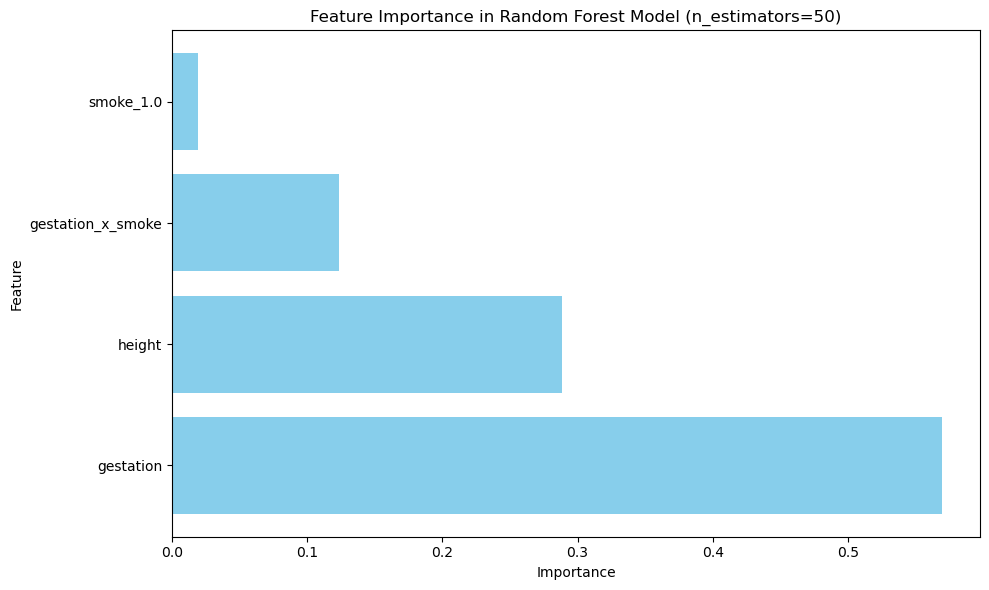

In [98]:
best_rf_model = RandomForestRegressor(n_estimators=50, random_state=42)
best_rf_model.fit(X_train_encoded, y_train)

feature_importance = best_rf_model.feature_importances_
feature_names = X_train_encoded.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

importance_df = importance_df.sort_values('Importance', ascending=False)

print("Feature Importance:")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model (n_estimators=50)')
plt.tight_layout()
plt.show()

- Gestation is the most important feature as it accounts for more than 0.5 of the model's predictive power. This makes sense as longer pregnancies gives more time for babies to develop and gain weight.
- Height is the second most important feature, accounting for almost 0.3 of the model's predictive power. Taller mothers tend to produce heavier babies.
- The interaction between smoking and gestation only accounts for around 0.12 of the model's predictive power. This indicates that the effect of gestation period on birth weight differs between smokers and non-smokers.
- Smoking is the least important feature, only accounting for 0.02 of the model's predictive power. Its interaction with gestation is more significant, which suggests that smoking primarily matters in how it modifies the relationship between gestation and birth weight rather than as a standalone predictor.

## Helpful resources 
Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment inside the code cell, or you can list them below. 

You do not need to cite the official python documentation.
